## Question 2

- Train an autoencoder model for anomaly classification
- Use the dataset assigned for your group.
- Train model only on normal set. 
- Reconstruct on the test set and show the reconstruction error.
- What is the latent dimension?
- Plot TSNE for the test set.
- What is the threshold value of reconstruction error to classify as normal or anomalous ?

	 
- Dataset: Melanoma/Non Melanoma dataset
- Normal set: Non Melanoma set
- Link: Use the split created in the last assignment from the train set.
- Students: [CS22B1003 : CS22B2031]


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import cv2
import os

2025-03-05 21:51:05.725304: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-05 21:51:05.831866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741191665.879831    3567 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741191665.892525    3567 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-05 21:51:05.973576: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Helper function to load and preprocess images
def load_images_from_folder(folder, label, img_size=(64, 64)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load the images
train_non_melanoma_images, train_labels = load_images_from_folder('non_melanoma', label=0)  


# Normalize the pixel values to [0, 1]
train_non_melanoma_images = train_non_melanoma_images.astype('float32') / 255.0


In [3]:
def build_autoencoder(input_shape, latent_dim=16):
    # Encoder
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 64x64 -> 32x32
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 32x32 -> 16x16
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 16x16 -> 8x8
    
    # Latent space (bottleneck layer)
    encoded = layers.Flatten()(x)
    encoded = layers.Dense(latent_dim, activation='relu')(encoded)

    # Decoder
    x = layers.Dense(8 * 8 * 128, activation='relu')(encoded)  # Reshape to start the decoder
    x = layers.Reshape((8, 8, 128))(x)
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # 8x8 -> 16x16
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # 16x16 -> 32x32
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # 32x32 -> 64x64
    decoded = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)  # 3 channels for RGB

    # Compile autoencoder model
    autoencoder = models.Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    
    return autoencoder

In [4]:
# Build and train the autoencoder using only non-melanoma images
autoencoder = build_autoencoder(input_shape=(64, 64, 3), latent_dim=32)
autoencoder.summary()


I0000 00:00:1741191706.468265    3567 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2281 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       262,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8192)           │       270,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 866,467 (3.31 MB)

 Trainable params: 866,467 (3.31 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Select the first 5000 images from the training and test sets
train_non_melanoma_images_subset = train_non_melanoma_images[:5000]



history = autoencoder.fit(train_non_melanoma_images_subset, train_non_melanoma_images_subset, 
                          epochs=50, 
                          batch_size=16, 
                          validation_data=(train_non_melanoma_images_subset, train_non_melanoma_images_subset))

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/50


I0000 00:00:1741191716.015623    3725 service.cc:148] XLA service 0x7ea0740116a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741191716.015783    3725 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-03-05 21:51:56.102191: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741191716.441096    3725 cuda_dnn.cc:529] Loaded cuDNN version 90300


  8/313 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0700 

I0000 00:00:1741191720.978758    3725 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - loss: 0.0218 - val_loss: 0.0063
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0059 - val_loss: 0.0047
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 9/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 10/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 11/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 12/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/st

In [6]:
# Reconstruct the test set
test_melanoma_images, test_melanoma_labels = load_images_from_folder('melanoma', label=1)  
test_melanoma_images = test_melanoma_images.astype('float32') / 255.0

test_melanoma_reconstructed = autoencoder.predict(test_melanoma_images)
# test_melanoma_reconstructed = autoencoder.predict(test_melanoma_images)

# Compute reconstruction errors
normal_error = np.mean(np.square(test_melanoma_reconstructed - test_melanoma_images), axis=(1, 2, 3))


# Print the reconstruction errors
print("Mean reconstruction error:", np.mean(normal_error))


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step
Mean reconstruction error: 0.00475466


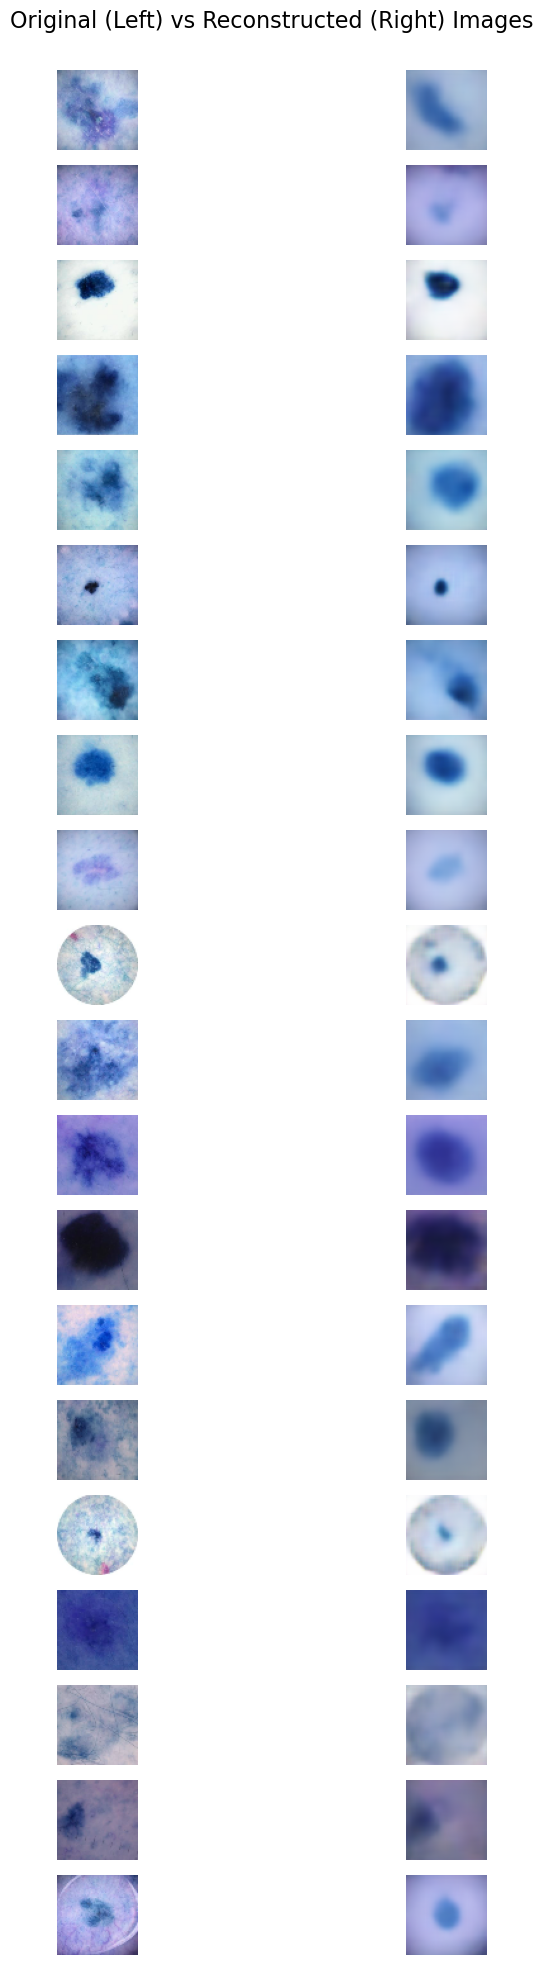

In [7]:
import matplotlib.pyplot as plt

# Show 20 original vs reconstructed images (side by side, original on the left, reconstructed on the right)
fig, axes = plt.subplots(20, 2, figsize=(10, 20))  # 20 rows, 2 columns (original and reconstructed)
plt.suptitle("Original (Left) vs Reconstructed (Right) Images", fontsize=16)

# Plot original and reconstructed images side by side
for i in range(20):
    # Plot original image on the left
    ax = axes[i, 0]
    ax.imshow(test_melanoma_images[i])  # Original image
    ax.axis('off')  # Hide the axis

    # Plot reconstructed image on the right
    ax = axes[i, 1]
    ax.imshow(test_melanoma_reconstructed[i])  # Reconstructed image
    ax.axis('off')  # Hide the axis

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top margin to fit the title
plt.show()


In [8]:
# Use the encoder to get the latent representations (encoded values)
encoder = models.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense').output)

# encoded_normal = encoder.predict(test_non_melanoma_images)
encoded_melanoma = encoder.predict(test_melanoma_images)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step 


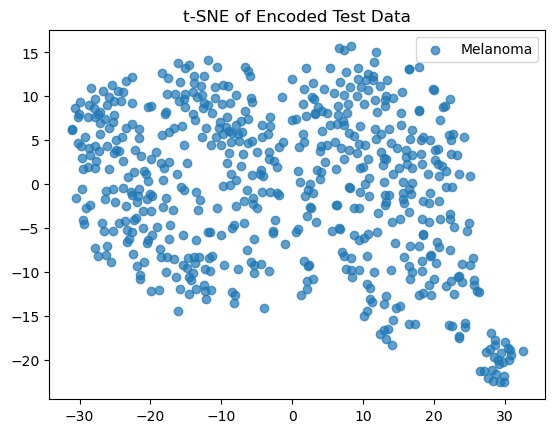

In [9]:
# Perform t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
# tsne_normal = tsne.fit_transform(encoded_normal)
tsne_melanoma = tsne.fit_transform(encoded_melanoma)

# Plot the t-SNE results
plt.scatter(tsne_melanoma[:, 0], tsne_melanoma[:, 1], label='Melanoma', alpha=0.7)
# plt.scatter(tsne_melanoma[:, 0], tsne_melanoma[:, 1], label='Melanoma', alpha=0.7)
plt.legend()
plt.title('t-SNE of Encoded Test Data')
plt.show()

In [10]:
# Set a threshold for classification
threshold = np.mean(normal_error) + 2 * np.std(normal_error)
print(f"Threshold for anomaly classification: {threshold}")

Threshold for anomaly classification: 0.01687697507441044


### Classifying images on Threshold

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Accuracy: 70.00%


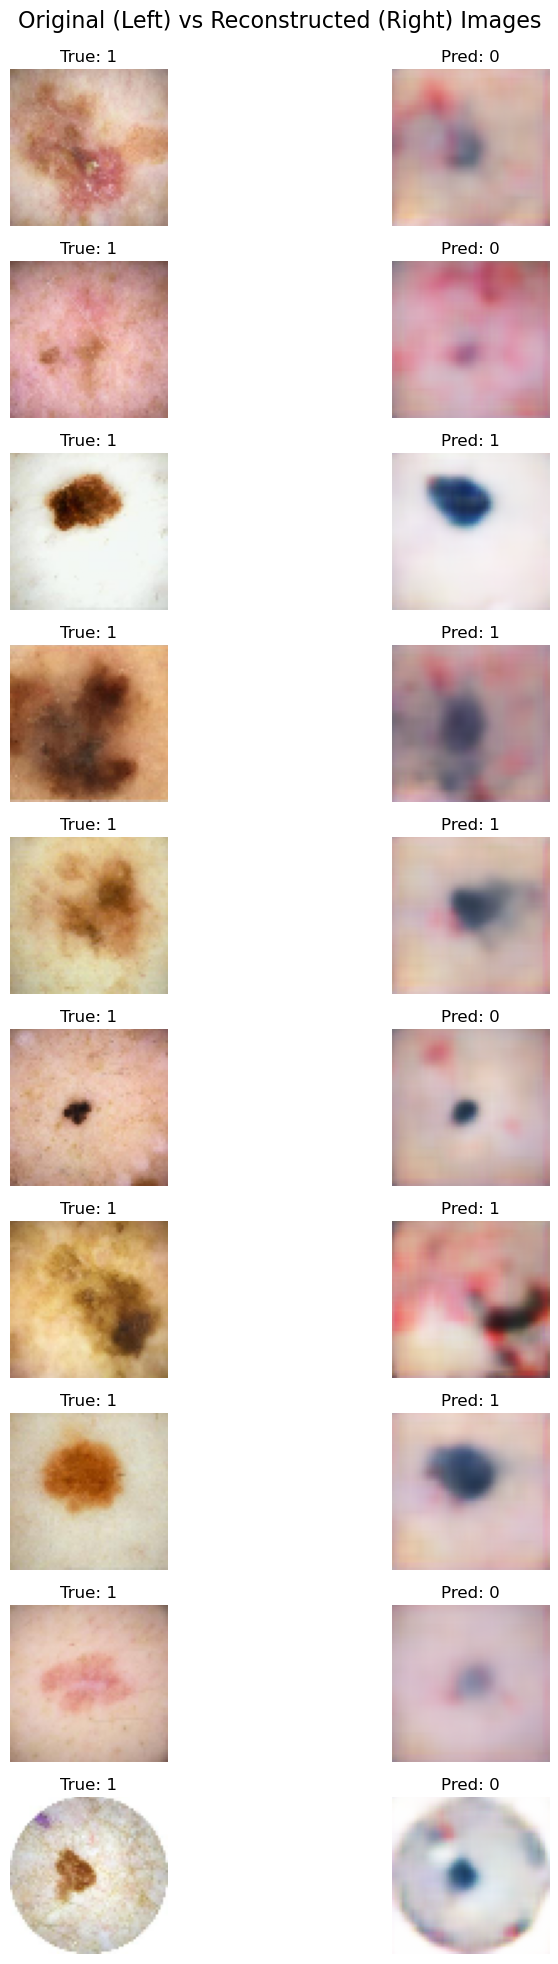

In [11]:
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Load your trained autoencoder model
# autoencoder = tf.keras.models.load_model('path_to_trained_autoencoder_model')

# Define the threshold
# threshold =  0.010291676269844174

# Function to load and preprocess images
def load_and_preprocess_image(image_path, target_size=(64, 64)):
    img = image.load_img(image_path, target_size=target_size)  # Resize to match model input size
    img_array = image.img_to_array(img) / 255.0  # Normalize the image
    return np.expand_dims(img_array, axis=0)  # Add batch dimension

# Function to calculate reconstruction error
def calculate_reconstruction_error(original_image, reconstructed_image):
    return np.mean(np.square(original_image - reconstructed_image))  # MSE

# Prepare the test data
def load_data(test_melanoma_dir, test_non_melanoma_dir, num_samples=10):
    # Get sample images from both classes
    melanoma_files = os.listdir(test_melanoma_dir)[:num_samples]
    non_melanoma_files = os.listdir(test_non_melanoma_dir)[:num_samples]

    images = []
    labels = []  # 1 for melanoma (anomaly), 0 for non-melanoma (normal)

    # Check if directories are empty
    if not melanoma_files:
        print(f"No files found in {test_melanoma_dir}.")
    if not non_melanoma_files:
        print(f"No files found in {test_non_melanoma_dir}.")

    # Load and preprocess melanoma images (label as 1)
    for file in melanoma_files:
        img_path = os.path.join(test_melanoma_dir, file)
        img = load_and_preprocess_image(img_path)
        images.append(img)
        labels.append(1)  # Melanoma is anomaly

    # Load and preprocess non-melanoma images (label as 0)
    for file in non_melanoma_files:
        img_path = os.path.join(test_non_melanoma_dir, file)
        img = load_and_preprocess_image(img_path)
        images.append(img)
        labels.append(0)  # Non-melanoma is normal

    # If images list is empty, return empty arrays
    if not images:
        print("No images were loaded. Please check the directory contents.")
        return np.array([]), np.array([])

    return np.vstack(images), np.array(labels)

# Define the directories for test data
test_melanoma_dir = 'melanoma'  # Replace with correct path
test_non_melanoma_dir ='non_melanoma'  # Replace with correct path

# Load the test data
test_images, true_labels = load_data(test_melanoma_dir, test_non_melanoma_dir, num_samples=10)

# Check if any images were loaded
if test_images.size == 0:
    print("No test images to process. Exiting.")
else:
    # Predict and calculate reconstruction errors
    predictions = []
    reconstructed_images = []
    original_images = []

    for img in test_images:
        # Ensure img has shape (1, height, width, channels) when passed to the model
        img = np.expand_dims(img, axis=0)  # If it's already in batch form, this will do nothing

        # Get the reconstructed image
        reconstructed_img = autoencoder.predict(img)

        # Save the original and reconstructed images for plotting later
        original_images.append(img[0])  # Storing the original image
        reconstructed_images.append(reconstructed_img[0])  # Storing the reconstructed image

        # Calculate reconstruction error
        reconstruction_error = calculate_reconstruction_error(img[0], reconstructed_img[0])

        # Classify based on the threshold
        if reconstruction_error > threshold:
            predictions.append(1)  # Anomaly (melanoma)
        else:
            predictions.append(0)  # Normal (non-melanoma)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Plot original and reconstructed images
    fig, axes = plt.subplots(10, 2, figsize=(10, 20))  # 10 rows, 2 columns for side-by-side images
    plt.suptitle("Original (Left) vs Reconstructed (Right) Images", fontsize=16)

    for i in range(10):
        # Plot original image
        ax = axes[i, 0]
        ax.imshow(original_images[i])  # Original image
        ax.axis('off')  # Hide the axis
        ax.set_title(f"True: {true_labels[i]}")

        # Plot reconstructed image
        ax = axes[i, 1]
        ax.imshow(reconstructed_images[i])  # Reconstructed image
        ax.axis('off')  # Hide the axis
        ax.set_title(f"Pred: {predictions[i]}")

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust the top margin to fit the title
    plt.show()


## Question 2

- Train an autoencoder model for anomaly classification
- Use the dataset assigned for your group.
- Train model only on normal set. 
- Reconstruct on the test set and show the reconstruction error.
- What is the latent dimension?
- Plot TSNE for the test set.
- What is the threshold value of reconstruction error to classify as normal or anomalous ?

	 
- Dataset: Melanoma/Non Melanoma dataset
- Normal set: Non Melanoma set
- Link: Use the split created in the last assignment from the train set.
- Students: [CS22B1003 : CS22B2031]


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import cv2
import os

2025-03-02 23:32:08.853008: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-02 23:32:08.886087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740938528.919281   70690 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740938528.926796   70690 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-02 23:32:08.951369: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Helper function to load and preprocess images
def load_images_from_folder(folder, label, img_size=(28, 28)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load the images
train_non_melanoma_images, train_labels = load_images_from_folder('non_melanoma', label=0)  


# Normalize the pixel values to [0, 1]
train_non_melanoma_images = train_non_melanoma_images.astype('float32') / 255.0
test_melanoma_images, test_melanoma_labels = load_images_from_folder('melanoma', label=1)  
test_melanoma_images = test_melanoma_images.astype('float32') / 255.0

In [3]:
def build_autoencoder(input_shape, latent_dim=16):
    # Encoder
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 64x64 -> 32x32
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 32x32 -> 16x16
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 16x16 -> 8x8
    
    # Latent space (bottleneck layer)
    encoded = layers.Flatten()(x)
    encoded = layers.Dense(latent_dim, activation='relu')(encoded)

   # Decoder
   # Decoder
    x = layers.Dense(7 * 7 * 128, activation='relu')(encoded)  # Adjust for 28x28 input -> 7x7 before reshaping
    x = layers.Reshape((7, 7, 128))(x)  # Reshape accordingly
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # 7x7 -> 14x14
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # 14x14 -> 28x28
    decoded = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)  # 3 channels for RGB


    # Compile autoencoder model
    autoencoder = models.Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    
    return autoencoder

In [4]:
# Build and train the autoencoder using only non-melanoma images
autoencoder = build_autoencoder(input_shape=(28, 28, 3), latent_dim=32)
autoencoder.summary()


W0000 00:00:1740938548.382395   70690 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6272)           │       206,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 3)      │         1,731 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 588,899 (2.25 MB)

 Trainable params: 588,899 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


2025-03-02 23:32:32.122408: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


2008/2008 ━━━━━━━━━━━━━━━━━━━━ 73s 35ms/step - loss: 0.0093 - val_loss: 0.0060
Epoch 2/30
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - loss: 0.0025 - val_loss: 0.0050
Epoch 3/30
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 73s 36ms/step - loss: 0.0023 - val_loss: 0.0052
Epoch 4/30
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 77s 38ms/step - loss: 0.0022 - val_loss: 0.0047
Epoch 5/30
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 125s 62ms/step - loss: 0.0021 - val_loss: 0.0047
Epoch 6/30
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 203s 101ms/step - loss: 0.0021 - val_loss: 0.0045
Epoch 7/30
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 201s 100ms/step - loss: 0.0021 - val_loss: 0.0048
Epoch 8/30
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 194s 97ms/step - loss: 0.0020 - val_loss: 0.0046
Epoch 9/30
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 76s 38ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 10/30
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 11/30
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 67s 33ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 12/30
2

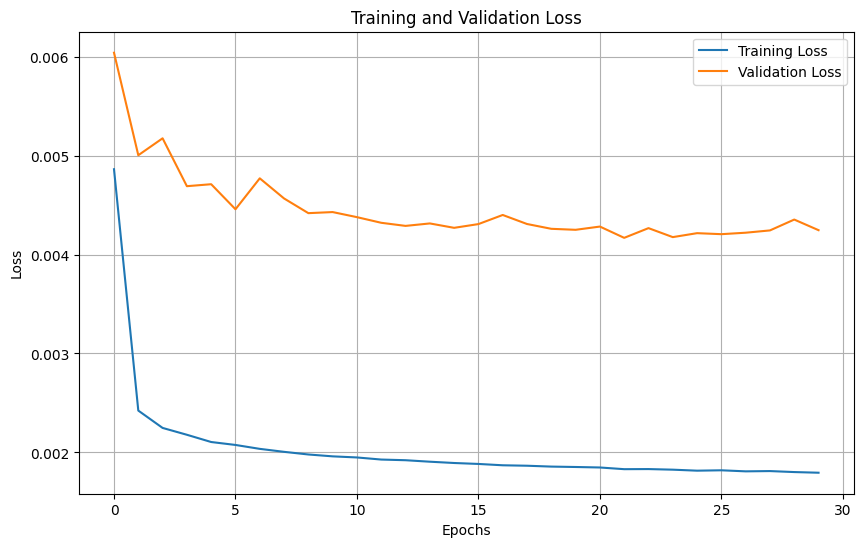

In [5]:
# Select the first 5000 images from the training and test sets
# train_non_melanoma_images_subset = train_non_melanoma_images[:5000]



history = autoencoder.fit(train_non_melanoma_images, train_non_melanoma_images, 
                          epochs=30, 
                          batch_size=16, 
                          validation_data=(test_melanoma_images, test_melanoma_images))

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# Reconstruct the test set
test_melanoma_images, test_melanoma_labels = load_images_from_folder('melanoma', label=1)  
test_melanoma_images = test_melanoma_images.astype('float32') / 255.0

test_melanoma_reconstructed = autoencoder.predict(test_melanoma_images)
# test_melanoma_reconstructed = autoencoder.predict(test_melanoma_images)

# Compute reconstruction errors
normal_error = np.mean(np.square(test_melanoma_reconstructed - test_melanoma_images), axis=(1, 2, 3))


# Print the reconstruction errors
print("Mean reconstruction error:", np.mean(normal_error))


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step 
Mean reconstruction error: 0.004246134


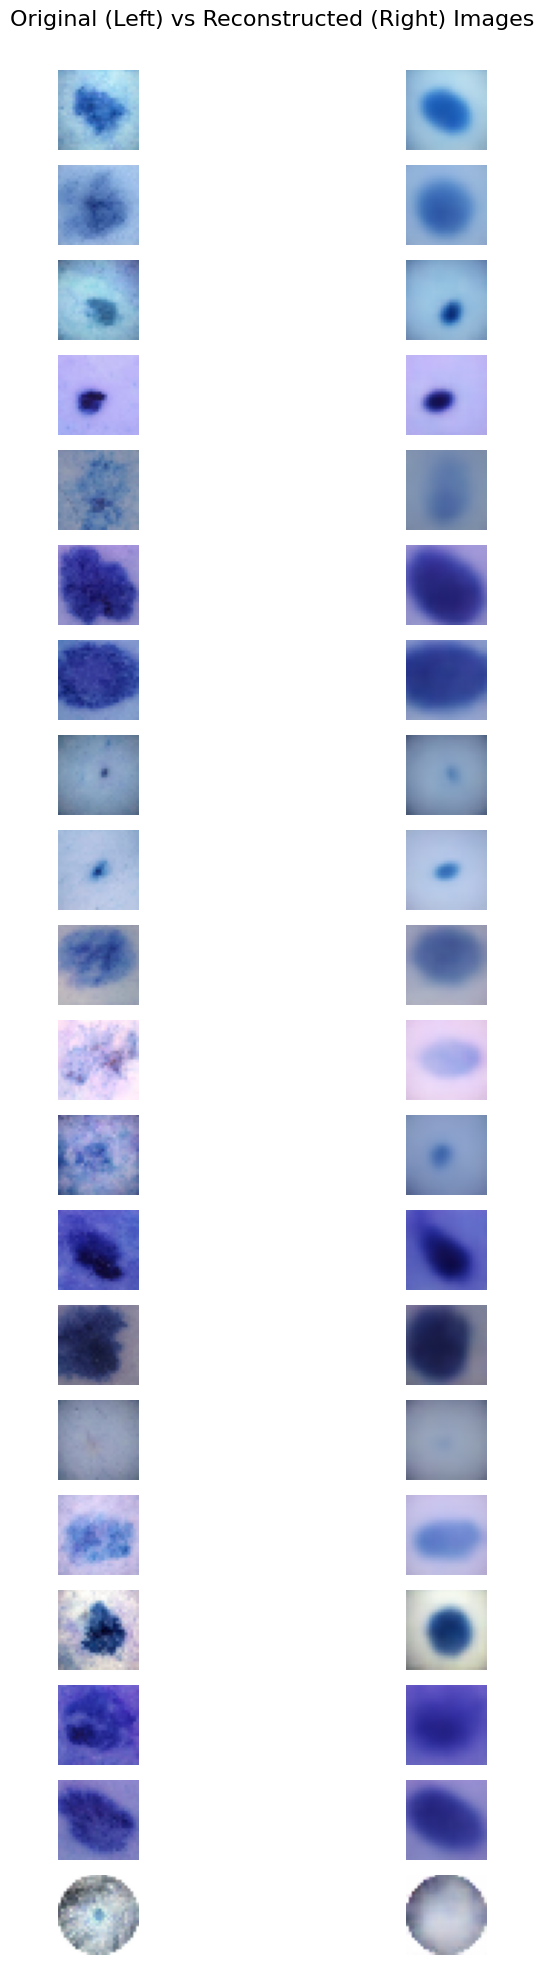

In [7]:
import matplotlib.pyplot as plt

# Show 20 original vs reconstructed images (side by side, original on the left, reconstructed on the right)
fig, axes = plt.subplots(20, 2, figsize=(10, 20))  # 20 rows, 2 columns (original and reconstructed)
plt.suptitle("Original (Left) vs Reconstructed (Right) Images", fontsize=16)

# Plot original and reconstructed images side by side
for i in range(20):
    # Plot original image on the left
    ax = axes[i, 0]
    ax.imshow(test_melanoma_images[i])  # Original image
    ax.axis('off')  # Hide the axis

    # Plot reconstructed image on the right
    ax = axes[i, 1]
    ax.imshow(test_melanoma_reconstructed[i])  # Reconstructed image
    ax.axis('off')  # Hide the axis

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top margin to fit the title
plt.show()


In [8]:
# Use the encoder to get the latent representations (encoded values)
encoder = models.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense').output)

# encoded_normal = encoder.predict(test_non_melanoma_images)
encoded_melanoma = encoder.predict(test_melanoma_images)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 


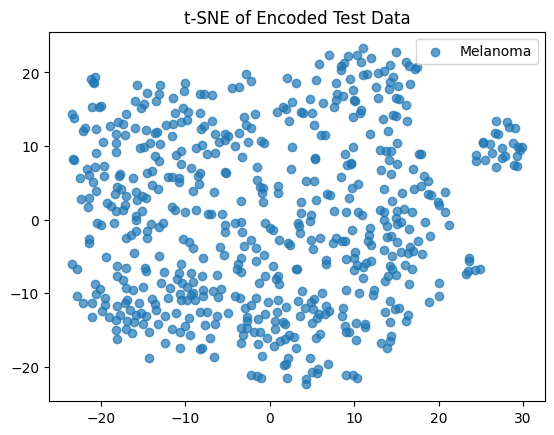

In [9]:
# Perform t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
# tsne_normal = tsne.fit_transform(encoded_normal)
tsne_melanoma = tsne.fit_transform(encoded_melanoma)

# Plot the t-SNE results
plt.scatter(tsne_melanoma[:, 0], tsne_melanoma[:, 1], label='Melanoma', alpha=0.7)
# plt.scatter(tsne_melanoma[:, 0], tsne_melanoma[:, 1], label='Melanoma', alpha=0.7)
plt.legend()
plt.title('t-SNE of Encoded Test Data')
plt.show()

In [10]:
# Set a threshold for classification
threshold = np.mean(normal_error) + 2 * np.std(normal_error)
print(f"Threshold for anomaly classification: {threshold}")

Threshold for anomaly classification: 0.012906234245747328


### Classifying images on Threshold

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Accuracy: 80.00%


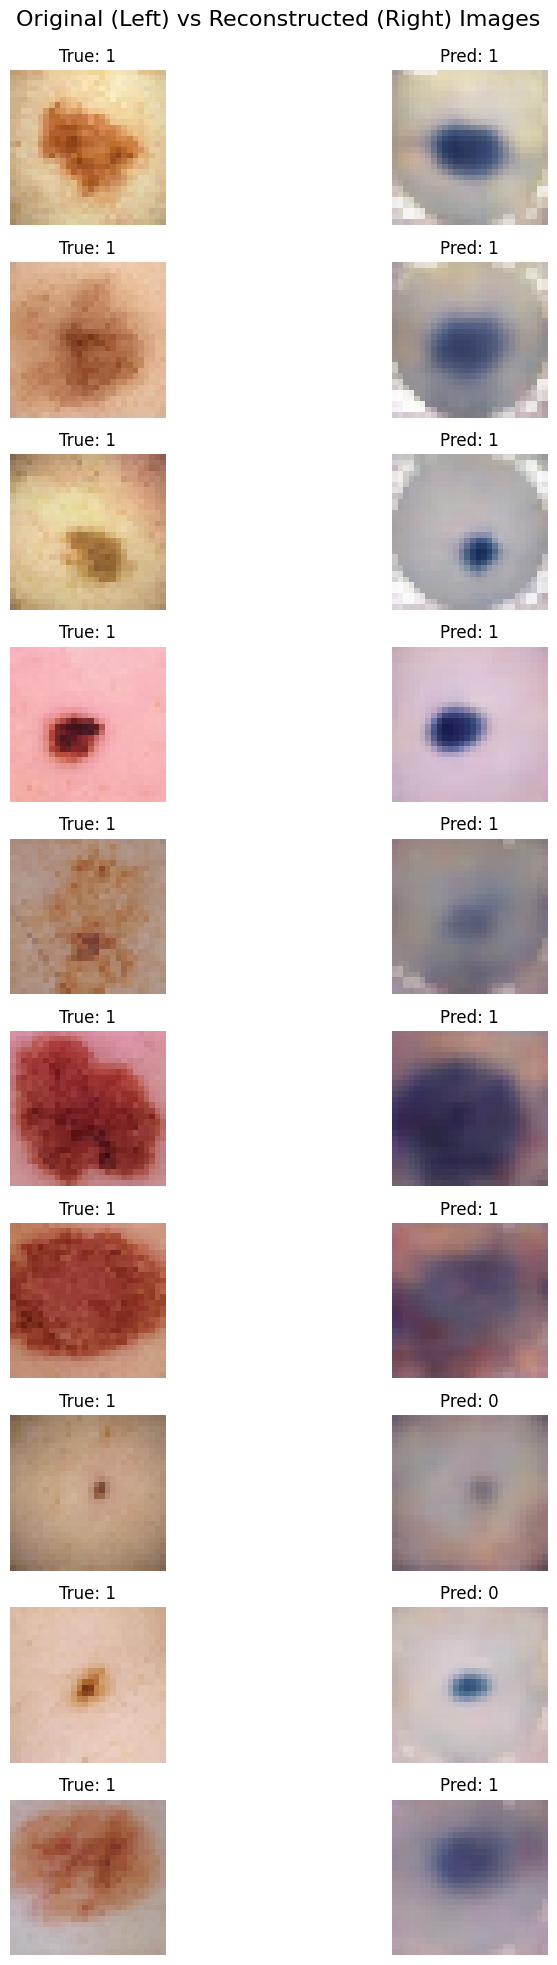

In [11]:
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Load your trained autoencoder model
# autoencoder = tf.keras.models.load_model('path_to_trained_autoencoder_model')

# Define the threshold
# threshold =  0.010291676269844174

# Function to load and preprocess images
def load_and_preprocess_image(image_path, target_size=(28, 28)):
    img = image.load_img(image_path, target_size=target_size)  # Resize to match model input size
    img_array = image.img_to_array(img) / 255.0  # Normalize the image
    return np.expand_dims(img_array, axis=0)  # Add batch dimension

# Function to calculate reconstruction error
def calculate_reconstruction_error(original_image, reconstructed_image):
    return np.mean(np.square(original_image - reconstructed_image))  # MSE

# Prepare the test data
def load_data(test_melanoma_dir, test_non_melanoma_dir, num_samples=10):
    # Get sample images from both classes
    melanoma_files = os.listdir(test_melanoma_dir)[:num_samples]
    non_melanoma_files = os.listdir(test_non_melanoma_dir)[:num_samples]

    images = []
    labels = []  # 1 for melanoma (anomaly), 0 for non-melanoma (normal)

    # Check if directories are empty
    if not melanoma_files:
        print(f"No files found in {test_melanoma_dir}.")
    if not non_melanoma_files:
        print(f"No files found in {test_non_melanoma_dir}.")

    # Load and preprocess melanoma images (label as 1)
    for file in melanoma_files:
        img_path = os.path.join(test_melanoma_dir, file)
        img = load_and_preprocess_image(img_path)
        images.append(img)
        labels.append(1)  # Melanoma is anomaly

    # Load and preprocess non-melanoma images (label as 0)
    for file in non_melanoma_files:
        img_path = os.path.join(test_non_melanoma_dir, file)
        img = load_and_preprocess_image(img_path)
        images.append(img)
        labels.append(0)  # Non-melanoma is normal

    # If images list is empty, return empty arrays
    if not images:
        print("No images were loaded. Please check the directory contents.")
        return np.array([]), np.array([])

    return np.vstack(images), np.array(labels)

# Define the directories for test data
test_melanoma_dir = 'melanoma'  # Replace with correct path
test_non_melanoma_dir ='non_melanoma'  # Replace with correct path

# Load the test data
test_images, true_labels = load_data(test_melanoma_dir, test_non_melanoma_dir, num_samples=10)

# Check if any images were loaded
if test_images.size == 0:
    print("No test images to process. Exiting.")
else:
    # Predict and calculate reconstruction errors
    predictions = []
    reconstructed_images = []
    original_images = []

    for img in test_images:
        # Ensure img has shape (1, height, width, channels) when passed to the model
        img = np.expand_dims(img, axis=0)  # If it's already in batch form, this will do nothing

        # Get the reconstructed image
        reconstructed_img = autoencoder.predict(img)

        # Save the original and reconstructed images for plotting later
        original_images.append(img[0])  # Storing the original image
        reconstructed_images.append(reconstructed_img[0])  # Storing the reconstructed image

        # Calculate reconstruction error
        reconstruction_error = calculate_reconstruction_error(img[0], reconstructed_img[0])

        # Classify based on the threshold
        if reconstruction_error > threshold:
            predictions.append(1)  # Anomaly (melanoma)
        else:
            predictions.append(0)  # Normal (non-melanoma)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Plot original and reconstructed images
    fig, axes = plt.subplots(10, 2, figsize=(10, 20))  # 10 rows, 2 columns for side-by-side images
    plt.suptitle("Original (Left) vs Reconstructed (Right) Images", fontsize=16)

    for i in range(10):
        # Plot original image
        ax = axes[i, 0]
        ax.imshow(original_images[i])  # Original image
        ax.axis('off')  # Hide the axis
        ax.set_title(f"True: {true_labels[i]}")

        # Plot reconstructed image
        ax = axes[i, 1]
        ax.imshow(reconstructed_images[i])  # Reconstructed image
        ax.axis('off')  # Hide the axis
        ax.set_title(f"Pred: {predictions[i]}")

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust the top margin to fit the title
    plt.show()
